In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
import re
import string
from sklearn.model_selection import learning_curve
import random
from transformers import BertTokenizer, BertModel

# Download necessary NLTK datasets
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jadal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jadal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jadal\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jadal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
data = pd.read_csv('data.csv')

In [29]:
data.head()

,condition_label,medical_abstract
0,5,Tissue changes around loose prostheses. A cani...
1,1,Neuropeptide Y and neuron-specific enolase lev...
2,2,"Sexually transmitted diseases of the colon, re..."
3,1,Lipolytic factors associated with murine and h...
4,3,Does carotid restenosis predict an increased r...


In [30]:
#checking for missing values: 
data.isnull().sum()

condition_label     0
medical_abstract    0
dtype: int64

In [31]:
#dimensions 
data.shape

(11550, 2)

In [32]:
map = {1: 'Neoplasms', 2: 'Digestive System Diseases',
       3: 'Nervous System Disease', 4: 'Cardiovascular Diseases',
       5: 'General Pathological Conditions'}

class_counts = data['condition_label'].map(map).value_counts()
print(class_counts)

General Pathological Conditions    3844
Neoplasms                          2530
Cardiovascular Diseases            2441
Nervous System Disease             1540
Digestive System Diseases          1195
Name: condition_label, dtype: int64


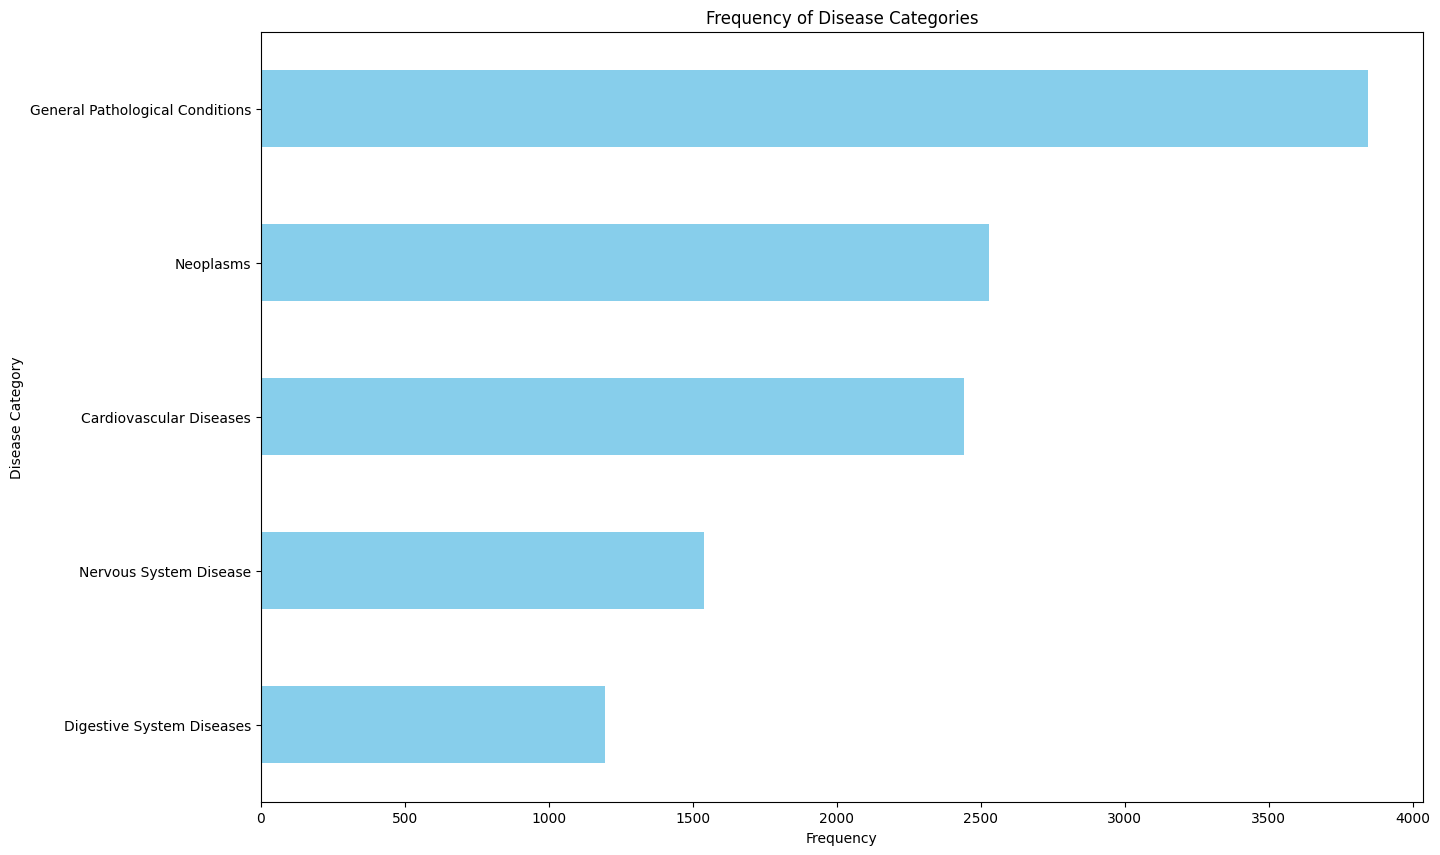

In [33]:
plt.figure(figsize = (15,10))
class_counts.plot(kind = 'barh', color = 'skyblue')
plt.xlabel('Frequency')
plt.ylabel('Disease Category')
plt.title('Frequency of Disease Categories')
plt.gca().invert_yaxis()
plt.show()

In [34]:
additional_samples = 3000

nervous_system_disease_additional = data[data['condition_label'] == 3].sample(n=additional_samples, replace=True)
digestive_system_diseases_additional = data[data['condition_label'] == 2].sample(n=additional_samples, replace=True)
neoplasms_additional = data[data['condition_label'] == 1].sample(n=additional_samples, replace=True)
cardiovascular_diseases_additional = data[data['condition_label'] == 4].sample(n=additional_samples, replace=True)
general_pathological_conditions = data[data['condition_label'] == 5].sample(n=additional_samples, replace=True)


new_data = pd.concat([
    general_pathological_conditions,
    nervous_system_disease_additional,
    digestive_system_diseases_additional,
    neoplasms_additional,
    cardiovascular_diseases_additional
])

new_data.reset_index(drop=True, inplace=True)

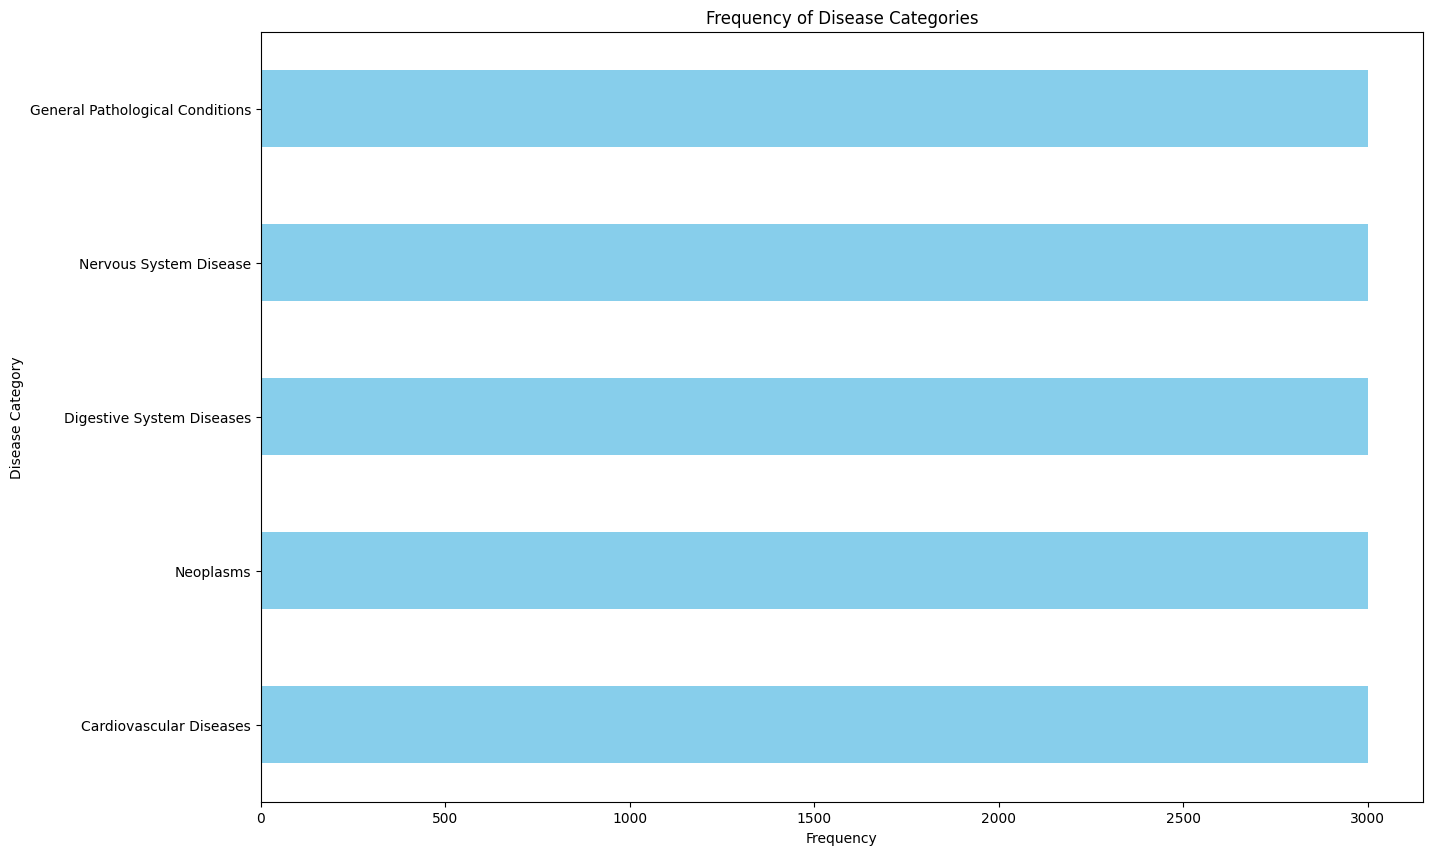

In [35]:
class_counts = new_data['condition_label'].map(map).value_counts()

plt.figure(figsize = (15,10))
class_counts.plot(kind = 'barh', color = 'skyblue')
plt.xlabel('Frequency')
plt.ylabel('Disease Category')
plt.title('Frequency of Disease Categories')
plt.gca().invert_yaxis()
plt.show()

In [36]:
from transformers import BertTokenizer, BertModel
import torch
import random

In [37]:
tokenizer = BertTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")
model = BertModel.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")

In [38]:
def augment_with_synonyms(text, tokenizer, num_augmented_samples=1):
    augmented_texts = []
    for _ in range(num_augmented_samples):
        augmented_tokens = []
        for token in tokenizer.tokenize(text):
            synonyms = wordnet.synsets(token)
            if synonyms:
                synonym = random.choice(synonyms).lemmas()[0].name()
                augmented_tokens.append(synonym)
            else:
                augmented_tokens.append(token)
        augmented_texts.append(" ".join(augmented_tokens))
    return augmented_texts

In [39]:
def augment_text(text):
    augmented_texts = augment_with_synonyms(text, tokenizer, num_augmented_samples = 3)
    return augmented_texts

In [40]:
new_data['medical_abstract'] = new_data['medical_abstract'].apply(augment_text)
new_data = new_data.explode('medical_abstract')
new_data.reset_index(drop=True, inplace=True)

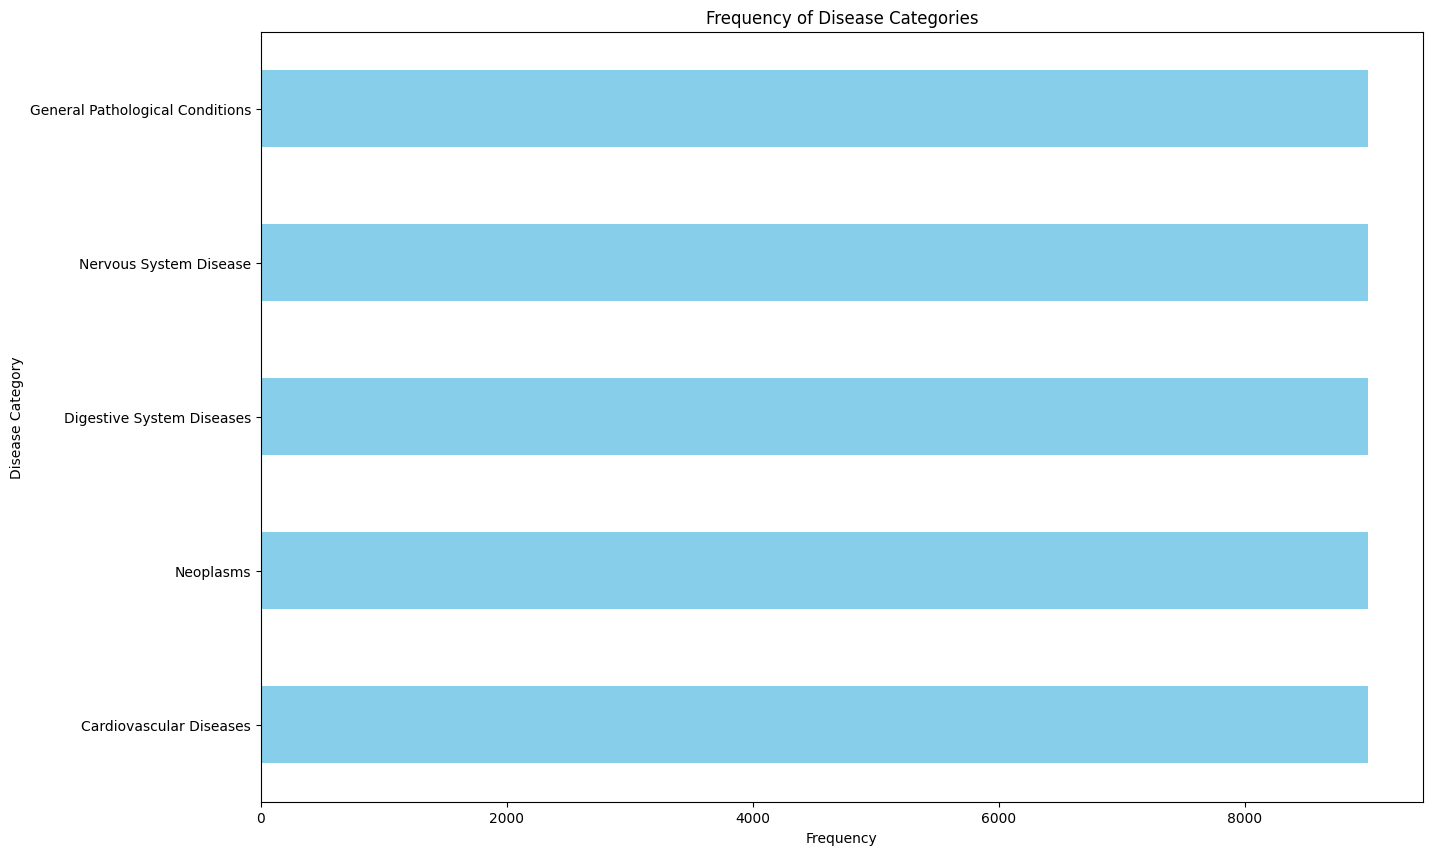

In [41]:
class_counts = new_data['condition_label'].map(map).value_counts()

plt.figure(figsize = (15,10))
class_counts.plot(kind = 'barh', color = 'skyblue')
plt.xlabel('Frequency')
plt.ylabel('Disease Category')
plt.title('Frequency of Disease Categories')
plt.gca().invert_yaxis()
plt.show()

In [42]:
def preprocess_text(content):

  content = content.strip()
  content = "".join([char for char in content if char not in string.punctuation])
  content = content.lower()
  content = re.sub(r'[^a-zA-Z0-9\s]', '', content)
  content = " ".join([word for word in content.split() if word not in set(stopwords.words('english'))])
  lemmatizer = nltk.stem.WordNetLemmatizer()
  content = " ".join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(content)])

  return content

In [43]:
new_data['medical_abstract'] = new_data['medical_abstract'].apply(preprocess_text)

In [44]:
new_data.shape

(45000, 2)

In [21]:
# shuffling the dataset 
new_data = new_data.sample(frac = 1)

In [22]:
# Transforming the dataframe into a csv file that will be used for working with learning mdoels.
new_data.to_csv('new_data.csv', index=False)